# Clustering  con HDBSCAN - Generacion de energia por region
En la ingenieria electrica, especificamente el enfasis de sistemas de potencia, la generacion de energia es una de las ramas principales de aplicacion. En muchos articulos academicos e investigaciones se analiza la generacion y consumo de enrgia en diferentes regiones y con multiples variables con el fin de optimizar este preciado recurso.

En este caso se tiene una base de datos con los resultados de diferentes mediciones de generacion de energia por tipo y por region, a su vez que la cantidad de energia a producir estimada en unidades de Medición fasorial. 

Las unidades de Medición fasorial como su nombre lo indica realizan una medida de los fasores de corriente y tensión de la red eléctrica, garantizando sincronización en las medidas y una alta tasa de muestreo que permite una visualización en tiempo real del sistema, siendo un factor clave para determinar flujos de potencia y en general el estado del sistema. El conjunto de dos o más PMU’s instaladas en el sistema y los software de análisis de datos provenientes de estas es llamado un WAMS de PMU’s. Todos los valores tomados, que se muestran en la base de datos estan en MU.

Se utilizara el metodo HDBSCAN para ordenar los datos en clusteres relacionados, con el fin de analizar caracteristicas geograficas y tecnicas de cada region.
Este algoritmo realiza DBSCAN sobre diferentes valores de épsilon e integra el resultado para encontrar un agrupamiento que brinde la mejor estabilidad sobre épsilon. 
Esto permite que HDBSCAN encuentre grupos de diferentes densidades (a diferencia de DBSCAN) y sea más robusto para la selección de parámetros.


In [217]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster

%matplotlib inline

## Importando Dataset y visualizando sus Caracteristicas

In [218]:
data = pd.read_csv('../datasets/generacion energia por tipo region.csv',engine='python')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   indice                            4945 non-null   int64  
 1   fecha                             4945 non-null   object 
 2   Region                            4945 non-null   object 
 3   Generacion Termica actual (MU)    4945 non-null   float64
 4   Generacion Termica Estimada (MU)  4945 non-null   float64
 5   Generacion Eolica Actual (MU)     4945 non-null   float64
 6   Generacion Eolica Estimada (MU)   4945 non-null   float64
 7   Hidro Generacion Actual (MU)      4945 non-null   float64
 8   Hidro Generacion Estimada (MU)    4945 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 347.8+ KB


## Mostrar las primeras filas para una previsualizacion del orden de los datos

In [219]:
data.head()

,indice,fecha,Region,Generacion Termica actual (MU),Generacion Termica Estimada (MU),Generacion Eolica Actual (MU),Generacion Eolica Estimada (MU),Hidro Generacion Actual (MU),Hidro Generacion Estimada (MU)
0,0,9/1/2017,Central y Norte,624.23,484.21,30.36,35.57,273.27,320.81
1,1,9/1/2017,Pacifico,1106.89,1024.33,25.17,3.81,72.00,21.53
2,2,9/1/2017,Zona Sur,576.66,578.55,62.73,49.80,111.57,64.78
3,3,9/1/2017,Caribe,441.02,429.39,38.94,36.45,85.94,69.36
4,4,9/1/2017,Huetar Norte,29.11,15.91,0.00,0.00,24.64,21.21


## Se puede ver que la columna "indice" es el indice numerico de la muestra, pero que ya se ha enumerado con el metodo de lectura, por ello, se procede a eliminarla

In [220]:
data = data.drop(['indice'],axis=1)
data.head()


,fecha,Region,Generacion Termica actual (MU),Generacion Termica Estimada (MU),Generacion Eolica Actual (MU),Generacion Eolica Estimada (MU),Hidro Generacion Actual (MU),Hidro Generacion Estimada (MU)
0,9/1/2017,Central y Norte,624.23,484.21,30.36,35.57,273.27,320.81
1,9/1/2017,Pacifico,1106.89,1024.33,25.17,3.81,72.00,21.53
2,9/1/2017,Zona Sur,576.66,578.55,62.73,49.80,111.57,64.78
3,9/1/2017,Caribe,441.02,429.39,38.94,36.45,85.94,69.36
4,9/1/2017,Huetar Norte,29.11,15.91,0.00,0.00,24.64,21.21


## Se obtienen las variables estadisticas de los datos por columna, para los valores numericos.

In [221]:
data_std = data.describe()
data_std
# En este punto se puede optar por un analisis de estos elementos, que caracterizan los datos procesado, puedido ralizar N componentes
# a los cuales aplicar metodos de agrupamiento y visualizarlos. 
# En este caso, se hara un enfoque directo con los datos y no sus variables estadisticas.

,Generacion Termica actual (MU),Generacion Termica Estimada (MU),Generacion Eolica Actual (MU),Generacion Eolica Estimada (MU),Hidro Generacion Actual (MU),Hidro Generacion Estimada (MU)
count,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000
mean,603.978358,575.395116,22.353199,22.200097,73.305921,76.842965
std,383.534208,383.387299,22.005852,20.188407,74.482145,82.043952
min,12.340000,12.380000,0.000000,0.000000,0.000000,0.000000
25%,470.050000,427.460000,0.000000,0.000000,26.910000,23.310000
50%,615.280000,535.980000,25.130000,28.540000,52.960000,50.270000
75%,689.530000,672.740000,34.020000,36.600000,85.940000,95.800000
max,1395.970000,1442.380000,68.740000,76.640000,348.720000,397.380000


## Estos datos son muy utiles para diferentes analisis de produccion y estimacion. Otra buena forma de tratar los datos es normalizandolos. 

Notese que este dataset mantiene datos numericos y no-numericos(texto) por lo que su procesamiento no se puede realizar de forma directa. En este caso existen varias formas de procesamiento y ordenamiento: Por fecha, por region o por valores numericos. Una posibilidad es tratar estos datos texto como numeros o etiquetas numericas, o simplemente omitiendolos del procesamiento numerico. Para esto, es posible crear un datase o un dataframe que contenga los valores a procesar, mientras se que guardan las etiquetas de texto en el vector original de datos o en otro lugar conocido para su procesamiento posterior.

In [222]:
# Se quitan las columnas fecha y region, que se dejaran como etiquetas posteriores.
data = data.drop(['fecha'],axis=1)
data = data.drop(['Region'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Generacion Termica actual (MU)    4945 non-null   float64
 1   Generacion Termica Estimada (MU)  4945 non-null   float64
 2   Generacion Eolica Actual (MU)     4945 non-null   float64
 3   Generacion Eolica Estimada (MU)   4945 non-null   float64
 4   Hidro Generacion Actual (MU)      4945 non-null   float64
 5   Hidro Generacion Estimada (MU)    4945 non-null   float64
dtypes: float64(6)
memory usage: 231.9 KB


In [223]:
# Ahora que se tienen todos los valores numericos, se normalizan los datos en un rango adecuado y se vuelven a obtener sus metricas:
data_norm = (data - data.min())/(data.max()-data.min())
data_norm.describe()

,Generacion Termica actual (MU),Generacion Termica Estimada (MU),Generacion Eolica Actual (MU),Generacion Eolica Estimada (MU),Hidro Generacion Actual (MU),Hidro Generacion Estimada (MU)
count,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000
mean,0.427599,0.393717,0.325185,0.289667,0.210214,0.193374
std,0.277194,0.268103,0.320132,0.263419,0.213587,0.206462
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.330804,0.290266,0.000000,0.000000,0.077168,0.058659
50%,0.435767,0.366154,0.365580,0.372390,0.151870,0.126504
75%,0.489430,0.461790,0.494908,0.477557,0.246444,0.241079
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Se puede observar que ahora los datos tienen valores entre cero y uno, max y min.
## Ahora con este preprocesamiento se tienen datos ordenados, numericos y normalizados, listos para un agrupamiento optimo.


In [224]:
# Configuracion del modelo HDBSCAN (una forma es aplicar fit_predict para evitar setear algunos parametros)
# un ejemplo de configuracion manual es: hdbscan_model = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,approx_min_span_tree=True,gen_min_span_tree=True,leaf_size=40,metric='euclidean',min_cluster_size=650, min_samples=3,p=None)

# Obtenemos el modelo
hdbscan_auto = hdbscan.HDBSCAN(min_cluster_size=700)    # Seleccion empirica de un unico parametro, que es intuitivo y facil de probar.

# Aplicar el modelo a los datos normalizados
cluster_labels = hdbscan_auto.fit_predict(data_norm)

# Podemos llamar a visualizar a las etiquetas de los grupos creados y analizar el conteo de estas etiquetas y su asignacion con una tabla cruzada
pd.crosstab(cluster_labels, columns='Cantidad Elementos')

col_0,Cantidad Elementos
row_0,
-1,671
0,916
1,991
2,957
3,1410


Se puede observar que con esta configuracion de parametros, HDBSCAN encuentra varios clusters con diferentes cantidades de elementos. HDBSCAN no tiene dificultados reconociendo los datos atipicos o outliers del dataset, como se puede ver en la agrupacion -1. Esta es una de las principales fortalezas del metodo.

<AxesSubplot:ylabel='$\\lambda$ value'>

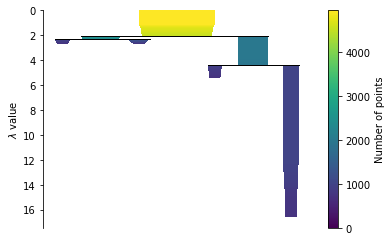

In [225]:
## Ahora se grafican estos resultados:
hdbscan_auto.condensed_tree_.plot()

Este metodo crea un atributo label_ dentro del modelo clustering generado. Se agrega esta calificacion al archivo original del Dataset:

In [226]:
data['HDBSCAN clusters'] = cluster_labels
data.head()

,Generacion Termica actual (MU),Generacion Termica Estimada (MU),Generacion Eolica Actual (MU),Generacion Eolica Estimada (MU),Hidro Generacion Actual (MU),Hidro Generacion Estimada (MU),HDBSCAN clusters
0,624.23,484.21,30.36,35.57,273.27,320.81,-1
1,1106.89,1024.33,25.17,3.81,72.00,21.53,-1
2,576.66,578.55,62.73,49.80,111.57,64.78,3
3,441.02,429.39,38.94,36.45,85.94,69.36,3
4,29.11,15.91,0.00,0.00,24.64,21.21,1


## Visualizacion de los clusters Generados
Ahora se pueden colorear los clusters generados en la imagen.

<AxesSubplot:ylabel='$\\lambda$ value'>

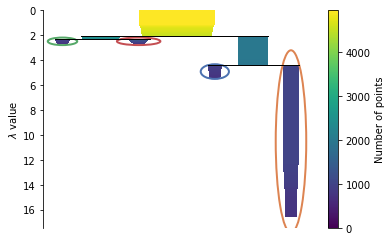

In [227]:
hdbscan_auto.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep',10))

In [228]:
# EL otro enfoque mencionado, es a partir de los datos estadisticos que mejor representen las relaciones del dataset, para ello se puede hacer uso del Analisis de COmponentes Principales (PCA)
from sklearn.decomposition import PCA

# Dos componentes principales
pca = PCA(n_components=2)                                  

# Aplicar transformacion
pca_data = pca.fit_transform(data_norm)

# Obtener DataFrame ordenado
pca_df = pd.DataFrame(data= pca_data, columns=['Componente_1', 'Componente_2'])

# Aplicar el modelo clustering HDBSCAN y obtener etiquetas ordenadas
hdbscan_auto_PCA = hdbscan.HDBSCAN(min_cluster_size=60)

labels = pd.DataFrame(data= hdbscan_auto_PCA.fit_predict(pca_df), columns=['HDBSCANS_Labels'])

# Agregar etiquetas de agrupaciones y dataframe en un solo arreglo
pca_df  = pd.concat([pca_df, labels], axis=1)

## Graficar el dataframe procesado
Ahora se configura la figura plot a mostrar con estos datos obtenidos

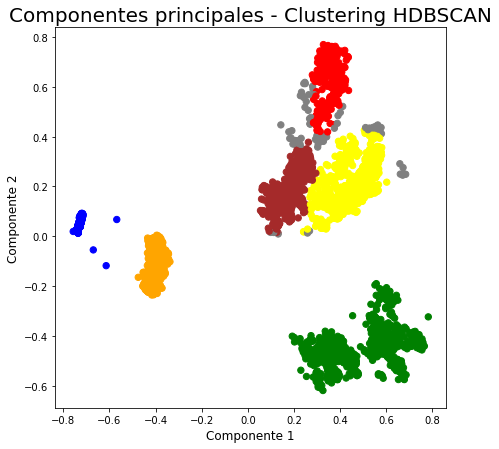

In [229]:
fig = plt.figure(figsize= (7,7))
grafico = fig.add_subplot(1,1,1)
grafico.set_xlabel('Componente 1',fontsize = 12 )
grafico.set_ylabel('Componente 2',fontsize = 12 )
grafico.set_title('Componentes principales - Clustering HDBSCAN',fontsize = 20 )
Colores = np.array(["blue", "orange", "green","yellow","red","brown","purple","pink","grey"])
grafico.scatter(x=pca_df.Componente_1 , y=pca_df.Componente_2, c=Colores[pca_df.HDBSCANS_Labels], s=40)
plt.show()

## Guardar los datos generados
Se procede a guardar el dataframe en formato csv. COmo se modifico el archido inicial, ahora se carga el original, se agregan las etiquetas generadas y se vuelve a guardar como csv ya con el clustering realizado.

In [230]:
csv = pd.read_csv('../datasets/generacion energia por tipo region.csv',engine='python')
csv['HDBSCAN_clusters'] = hdbscan_auto.labels_
csv.to_csv('../Results/energy-HDBSCAN.csv')   # Se crea un archivo csv en la carpeta Results

# Ejercicios/ Experimentos propuestos

## 1. Elija diferentes valores aleatorios para el numero MINIMO de clusters a implementar en el modelo HDBSCAN ¿Como cambia el resultado? ¿Que se nota?
## 2. Investigue cuales son los parametros configurables del metodo HDBSCAN (los mostrados en el comentario del codigo) y que determinan cada uno de ellos.
## 3. Implemente el modelo HDBSCAN con estos parametros seteados a su parecer. ¿Que cambia?
## 4. Explique las ventajas y desventajas que tiene el algoritmo HDBSCAN. Puede investigar diferentes fuentes.
## 5. Aumente el numero de PCA a 3 componentes y grafiquelo en 3 Dimensiones. ¿Que es lo que cambio y que se esta añadiendo?